# LoRaDongle Data Analysis Notebook

# Useful Links:

1. [Select Row from DataFrame based on Column Value](https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values)
2. [Get Cell Value from Dataframe](https://sparkbyexamples.com/pandas/pandas-get-cell-value-from-dataframe/)
3. [How to Fix in Pandas: KeyError: “[‘Label’] not found in axis”](https://www.statology.org/pandas-keyerror-label-not-found-in-axis/)
4. [Seaborn Tutorial in Python For Beginners](https://www.mygreatlearning.com/blog/seaborn-tutorial/)
5. [Github for useful plotting library](https://github.com/garrettj403/SciencePlots)
6. [Pandas Plotting Info (describes the different kinds of plots)](https://www.dataquest.io/blog/plot-dataframe-pandas/)

In [194]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [195]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [196]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [197]:
pip install scienceplots

Note: you may need to restart the kernel to use updated packages.


In [198]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


## Imports
Starts with importing the relevant packages

In [199]:
import csv, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scienceplots
import scipy

## Global Variables
The variables that will be used in the notebook:
* List of the directories
* Data stored in a dictionary of lists, with the directories being keys and the list having csvs in a dataframe

In [200]:
data = {}
directories = ['latency_tests/','menzies_tests/','parkade_tests/', 'outdoor_cbd/', 'outdoor_los/']

# Reading Information CSVs
(Will likely be more important for actual analysis)

In [201]:
#for i, directory in enumerate(directories):
#    csv_name = directory + 'tests_info.csv'
#    info[directory] = pd.read_csv(csv_name)

#info[directories[0]] = pd.read_csv('latency_tests/tests_info.csv')
#print(info)

latency_info =  pd.read_csv('latency_tests/tests_info.csv')
indoor_tests_info = pd.read_csv('parkade_tests/tests_info.csv')
#line_of_sight_info = pd.read_csv('outdoor_los/tests_info.csv')
#cbd_info = pd.read_csv('outdoor_cbd/tests_info.csv')

# Reading Data CSVs
(probably not useful)

In [202]:
for i, directory in enumerate(directories):
    count = 0
    data[directory] = []
    for path in os.listdir(directory):
        # check if current path is a file
        if os.path.isfile(os.path.join(directory, path)):
            count += 1
        
    print(f'File count in {directory}:  {count}')

    #reading every csv, might need to keep track of test_number? or read csv indiviaidually!
    #for j in range(1,count):
    #    csv_name = directories[i] + 'Test_' + str(j) + '.csv'
        #print(csv_name)
   #     data[directory].append(pd.read_csv(csv_name))
        


File count in latency_tests/:  7
File count in menzies_tests/:  14
File count in parkade_tests/:  38
File count in outdoor_cbd/:  6
File count in outdoor_los/:  7


# Analysis Plan
With CSVs read, the goal is to print graphs for all the tests performed. Graphs should tell me things such as:
* Percentage of successful messages
* Average transmit latency
* Average Round Time Latencies
* Graph of SNRs and RSSIs
  * Distance vs RSSI
  * Distance vs SNR


New plan for reading and handling csvs:
It seems like it would be easier to use tests_info.csv to iterate through CSVs in that folder and then extract the information you need from each csv. As opposed to reading all of them at once and struggling through.

Advice from mauro: load all csvs into a large dataframe and add columns from the tests_info.csv. that way can just filter out the various sections needed for analysis and plotting. will try implement that.

# Latency Analysis
Probably best to show it as a table. Should show average latency for each configuration! Therefore, iterate through config csvs and extract the necessary data
Basically create a new dataframe of read CSVs

Structure of analysis:
For every line in  test_info.csv (which is a test descriptor), read the corresponding csv and extract the average latency.
Then store it in the master latency dataframe.

In [203]:
latency_columns = ['Configuration', "Average Tx Time", "Average Round Trip Time"]#, "Max Tx Time", "Min Tx Time"]  #for now, configuration corresponds to test number, for latency testing there should really be only six tests
latency_results = {}

for column in latency_columns:
    latency_results[column] = []        #Initialising dictionary keys with empty lists


#obtaining the list of tests (hence files) in the directory
tests = latency_info["Test Number"].tolist()

#opening and extracting necessary info per csv
for test_num in tests:

    test_config = latency_info.loc[latency_info["Test Number"] == test_num]["Configuration"]
    #print(test_config) TODO: get the config of the test number and then use that to append to latency results configuration list

    #start with adding the configuration to latency results
    latency_results['Configuration'].append(test_num)

    #reading required test csv
    csv_name =   "latency_tests/Test_" + str(test_num) + ".csv"
    test_csv = pd.read_csv(csv_name)

    #### Obtaining Average Tx
    average_latency = test_csv["Time to Send"].mean()
    #print(average_latency)
    latency_results['Average Tx Time'].append(int(round(average_latency,0)))

    ### Obtaining Average Rx
    average_rx = test_csv["Time to Receive"].mean()
    latency_results['Average Round Trip Time'].append(int(round(average_rx,0)))

    #### Obtaining Max
    max_latency = test_csv["Time to Send"].max()
    #latency_results['Max Tx Time'].append(int(round(max_latency, 0)))

    #### Obtaining Min
    min_latency = test_csv["Time to Send"].min()
    #latency_results['Min Tx Time'].append(int(round(min_latency, 0)))


#convert results to dataframe
latency_df = pd.DataFrame.from_dict(latency_results)
print(latency_df)

   Configuration  Average Tx Time  Average Round Trip Time
0              1              549                     1194
1              2             2762                     5635
2              3             9236                    18630
3              4              699                     1491
4              5             3601                     7314
5              6            12067                    24294


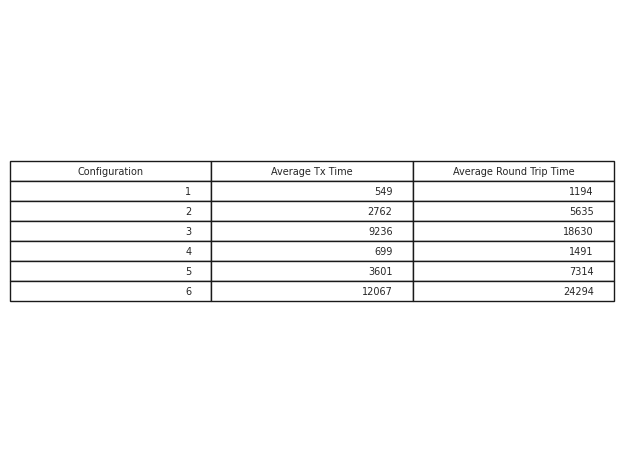

In [204]:

###############################Plotting table#################################### (just to see in table form, not needed for final graph)
# (Not that useful for final report)


#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#create table
table = ax.table(cellText=latency_df.values, colLabels=latency_df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

# Indoor Testing Analysis
Want to display the data as how each configuration responds due to the floor difference. So for example will look at a dloor differnce of two, will want to plot the % success rate of each configuration, the snr and rssi's of the configs as well.

The story to be told is eg: "looking at floor 3, configs 5-6 performed much better than configs 1-2"

Processing challenge will be:
1. Read info file
2. Filter by floor difference, horizontal distance
3. then filter by config
4. then read the test csvs of that config and that floor differnce
5. Pull the necessary data, appending it to whatever new dataframe that you have that will then plot the graphs.
6. Rinse and repeat

## 1 Floor Difference

### Parsing Data
Generating the list of and dictionary of all tests done with one floor difference

In [205]:

# Extract files info with 1 floor difference
floor_1_diff = indoor_tests_info.loc[indoor_tests_info["Floor Difference"] == 1]
#print(floor_1_diff.head())

test_nums = floor_1_diff["Test Number"].tolist()
configs=floor_1_diff["Configuration"].to_list()
#print(configs)
#print(test_nums)

# {Test Number: Configuration}
test_configs = floor_1_diff.set_index("Test Number").to_dict()["Configuration"]
print(test_configs)
#print(floor_1_diff["Configuration"])


{3: 1, 4: 2, 7: 3, 10: 4, 13: 5, 16: 6}


### Success Rate
Breaking down csvs and creating one dataframe that stores success rate of the six different configs over one floor difference


In [206]:
#print(indoor_tests_info)
success_rate_columns = ["Config", "Success Rate"]
success_rate_dict = {}

for column in success_rate_columns:
    success_rate_dict[column] = []


In [207]:
# Going through tests ad obtaining %passes per test
for test_num in test_nums:
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    
    # Counting the number of trues for current test, converting to dictionary
    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    current_success_rate = current_success_rate.to_dict()

    success_rate_dict["Config"].append(test_configs[test_num])
    success_rate_dict["Success Rate"].append(current_success_rate[True] * 100)



success_rate_df = pd.DataFrame.from_dict(success_rate_dict)


#### Plotting Graph (?)
Basically best way to show the success rate of the first floor tests, thinking just a table is good enough

In [208]:
print(success_rate_df)

   Config  Success Rate
0       1    100.000000
1       2    100.000000
2       3     96.666667
3       4     96.551724
4       5    100.000000
5       6     96.666667


### RSSI, RSSI Despread and SNR

Need to figure out difference between rssi and rssi despread

#### 1. Setting up Dataframe column titles

In [209]:
# May not be necessary for adding to the list easily
rssi_columns = ["Config", "RSSI", "Rssi Despread"]
columns = ["Configuration 1", "Configuration 2", "configuration 3", "Configuration 4", "Configuration 5", "Configuration 6"]
rssi_dict = {}
rssi_d_dict = {}
snr_dict = {}


#### 2. Obtaining RSSI Value for all 1st floor transmits

In [210]:
for test_num, configuration in test_configs.items():       #Iterating through tests with current floor difference
    test_name =     test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)
    
    #print("Test Number " + str(test_num) + ", With configuration " + str(configuration))
    rssis = test_df['RSSI'].to_list()
    rssi_ds = test_df['RSSI Despread'].to_list()
    snrs = test_df['SNR'].to_list()
    
    rssi_dict["Configuration " + str(configuration)] = rssis
    rssi_d_dict["Configuration " + str(configuration)] = rssi_ds
    snr_dict[str(configuration)] = snrs
    

rssi_df_1floor = pd.DataFrame.from_dict(rssi_dict)
rssid_df_1floor = pd.DataFrame.from_dict(rssi_d_dict)
snr_df_1floor = pd.DataFrame.from_dict(snr_dict)

#### 4. Plotting

<AxesSubplot: title={'center': 'SNR For Six Configurations at 1 Floor Difference'}, xlabel='Ping ID', ylabel='SNR'>

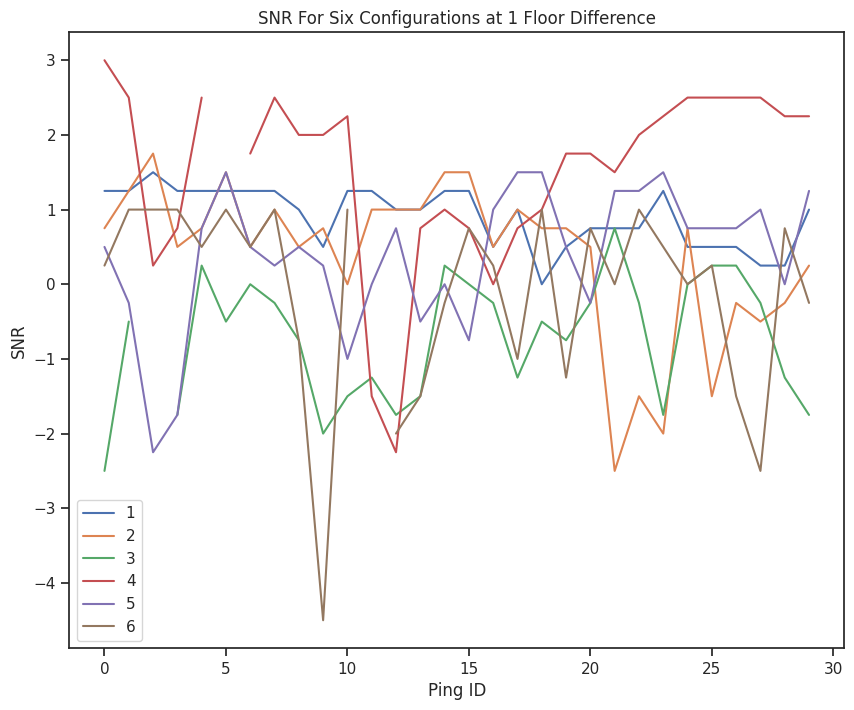

In [211]:
# Signal to noise ratios
snr_df_1floor.plot(figsize=(10,8), title="SNR For Six Configurations at 1 Floor Difference", ylabel="SNR", xlabel="Ping ID")

1    0.908333
2    0.375000
3   -0.715517
4    1.508621
5    0.375000
6   -0.103448
dtype: float64

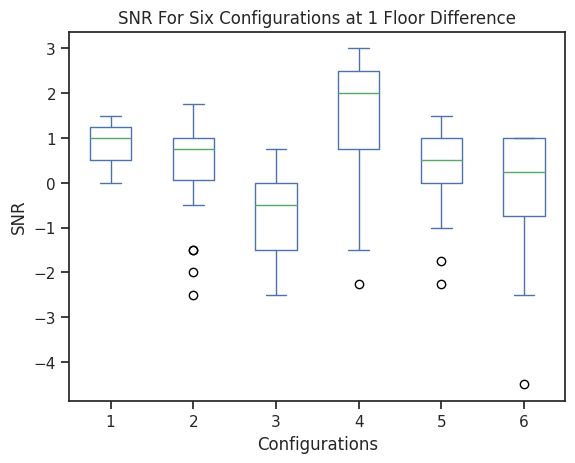

In [220]:
#sns.set_style('ticks')
snr_df_1floor.plot(kind="box", title="SNR For Six Configurations at 1 Floor Difference",ylabel="SNR", xlabel="Configurations")
snr_df_1floor.mean()

In [221]:
# RSSI Plotting
#rssi_df_1floor.plot(kind="box")
rssi_df_1floor.mean()

Configuration 1   -41.016667
Configuration 2   -41.666667
Configuration 3   -42.672414
Configuration 4   -44.896552
Configuration 5   -45.900000
Configuration 6   -46.672414
dtype: float64

<AxesSubplot: >

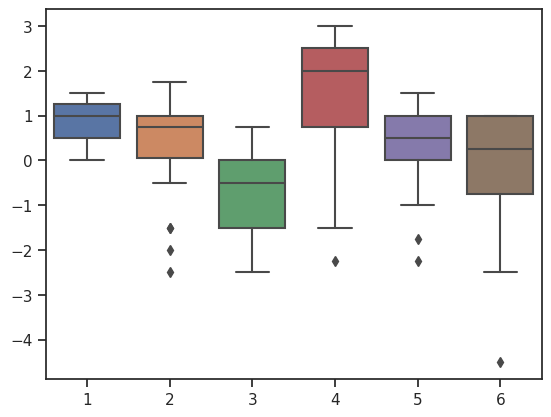

In [219]:
sns.boxplot(data=snr_df_1floor)